In [1]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time

np.random.seed(42)

In [2]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data+'filtered_jmpool_kin.h5','r')
lengths = np.array(f['MetaData/lengths_data'],dtype=int)
bouttypes= ma.array(f['bout_types'], dtype=int)
# stims = ma.array(f['stims'])
# ecs = ma.array(f['eye_convergence'])

##shapes are n_fish, max_n_bouts,dim of variable

bouttypes_allcond= ma.array(f['bout_types'])
stims_allcond = ma.array(f['stims'])
ecs_allcond = ma.array(f['eye_convergence'])
time_Bout_allcond = ma.array(f['times_bouts']) #raw times bouts

#shapes are n_fish, max_n_bouts,dim of variable
X_head_allcond = ma.array(f['head_pos'])
phi_smooth_allcond = ma.array(f['orientation_smooth'])
speeds_head_allcond = ma.array(f['speed_head'])
f.close()

In [3]:
time_Bout_allcond[time_Bout_allcond == 0] = ma.masked
X_head_allcond[X_head_allcond == 0] = ma.masked
phi_smooth_allcond[phi_smooth_allcond == 0] = ma.masked
speeds_head_allcond[phi_smooth_allcond.mask] = ma.masked
bouttypes_allcond[bouttypes_allcond == 15] = ma.masked
ecs_allcond[ecs_allcond == 100] = ma.masked

In [4]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[453,463],[121,133],[49,109],[22,49],[163,193],[109,121],
                           [133,164],[443,453],[0,22],
                           [193,258],[304,387],[258,273],[273,304],
                           [387,443]])

In [6]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data + 'kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()


In [7]:
to_mask = 1300
maxL = np.max(lengths_all)

labels_fish[labels_fish == to_mask] = ma.masked

In [8]:
## Select Dataset
np.random.seed(42)
seeds = np.random.randint(0,10000,100)
delay_range = np.arange(1,20,1)
dt = 1
div= 463
n_modes=50
labels_all= ma.concatenate(labels_fish,axis=0)
print(labels_fish.shape)

(463, 11651)


In [9]:
P_ensemble = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/P_ensemble_ex8_N1200_s8684.npy')

In [10]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
inv_measure = op_calc.stationary_distribution(P_ensemble)
final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)

In [11]:
# Load eigenfunctions

# eigfunctions = np.load(path_to_filtered_data + 'eigfs_n1200.npy')
phi1 = eigfunctions[:,1]
phi2 = eigfunctions[:,2]
phi3 = eigfunctions[:,3]

# Uncomment to discover eigenfunctions and eigenvalues from ensemble transition matrix. 
# The estimation of eigenvalues is done through ARPACK, which is stochastic in nature. 
# This can result in the eigenvectors flipping sign. 
# If that happens, you can change the random seed in op_calc.sorted_spectrum()

# from scipy.sparse import diags,identity,coo_matrix, csr_matrix
# P_ensemble = csr_matrix(P_ensemble)

# import msmtools.estimation as msm_estimation
# delay = 3
# dt = 1
# print(delay)
# # lcs_ensemble,P_ensemble = op_calc.transition_matrix(labels_all,delay,return_connected=True)
# R = op_calc.get_reversible_transition_matrix(P_ensemble)
# eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=123) 
# sorted_indices = np.argsort(eigvals.real)[::-1]
# eigvals = eigvals[sorted_indices][1:].real
# eigvals[np.abs(eigvals-1)<1e-12] = np.nan
# eigvals[eigvals<1e-12] = np.nan
# t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
# eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
# eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
# eigfunctions_traj[final_labels.mask] = ma.masked

3


In [12]:
split_locs = []
distorted_eigfs = np.zeros((eigfunctions.shape[0], eigfunctions.shape[1]-1))
for i in range(1,eigfunctions.shape[1]):
    phi = eigfunctions[:,i]
    _,_,_,split_idx,_ = op_calc.optimal_partition(phi,inv_measure,P_ensemble,return_rho=True)

    sort_range = np.sort(phi)
    neg_range = np.linspace(-1,0, len(sort_range[0:split_idx]))
    pos_range = np.linspace(0,1,len(sort_range[split_idx:]))
    distort_r = np.hstack([neg_range,pos_range])
    distort = np.zeros(phi.shape)

    pos = [np.where(phi == a)[0][0] for a in np.sort(phi)]

    for j in range(phi.shape[0]):
        distort[pos[j]] = distort_r[j]

    distorted_eigfs[:,i-1] = distort
    split_locs.append(split_idx)

In [13]:
distorted_trajs = ma.array(distorted_eigfs)[final_labels,:]
distorted_trajs[final_labels.mask] = ma.masked

distorted_fish = distorted_trajs.reshape(labels_fish.shape[0], labels_fish.shape[1], -1)

dtrajs_fish_phi1 = distorted_fish[:,:,0]
dtrajs_fish_phi2 = distorted_fish[:,:,1]

In [14]:
kms = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/pool_ex8_PCs/cg2_labels.npy')
kmeans_labels = kms
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask

### Light 5x5

In [15]:
cond = 0
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]
print(cond_recs)

# a = np.arange(condition_recs[9][0],condition_recs[9][1])
# b = np.arange(condition_recs[5][0],condition_recs[5][1])

# recs_ind = np.hstack([a,b])

maxL = np.max(lengths_all[cond_recs])

Light (5x5cm)
[453 454 455 456 457 458 459 460 461 462]


In [16]:
print(maxL)

time_Bout = time_Bout_allcond[cond_recs,:maxL]
X_head = X_head_allcond[cond_recs,:maxL]

stims = stims_allcond[cond_recs, :maxL]
bouttypes = bouttypes_allcond[cond_recs, :maxL]

2583


In [17]:
# recs_ind = np.hstack([a,b])

maxL = np.max(lengths_all[cond_recs])
# maxL = np.max(lengths_all[recs_ind])

dtrajs_condition_phi1 = dtrajs_fish_phi1[cond_recs,:maxL]
dtrajs_condition_phi2 = dtrajs_fish_phi2[cond_recs,:maxL]

# dtrajs_condition = dtrajs_fish[recs_ind,:maxL]
print(dtrajs_condition_phi2.shape)

(10, 2583)


<ipython-input-18-94a427e26658>:20: UserWarning: linewidths is ignored by contourf
  im = ax.contourf(X,Y, img, cmap='Greys', linewidths=2, levels = 17)


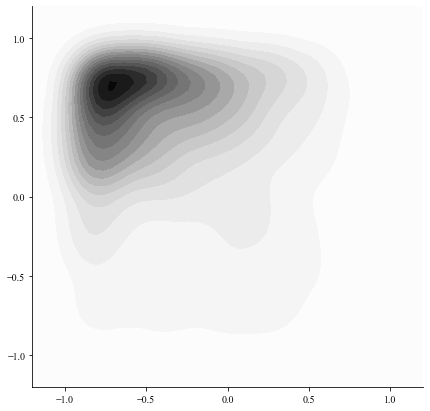

In [18]:
fig, ax  = plt.subplots(1,1,figsize=(7, 7))

# psi1[ecs_all.mask] = ma.masked
# psi2[ecs_all.mask] = ma.masked

xrange=[-1.2, +1.2]
yrange=[-1.2, +1.2]


psi1 = ma.concatenate(dtrajs_condition_phi1, axis=0)
psi2 = ma.concatenate(dtrajs_condition_phi2, axis=0)


# img= stats.density_plot(psi1.compressed()[::100], psi2.compressed()[::100], xrange, yrange, 50,50,smooth=True, border=3)

img= stats.density_plot(psi1.compressed(), psi2.compressed(), xrange, yrange, 50,50,smooth=True, border=3)


X,Y = np.meshgrid(np.linspace(-1.2,1.2,56), np.linspace(-1.2,1.2,56))
im = ax.contourf(X,Y, img, cmap='Greys', linewidths=2, levels = 17)


# im = ax.imshow(img, cmap='inferno', origin='lower')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.colorbar(im, ax=ax)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig3/lightlarge_mes_new.pdf')

In [19]:
cond = 0
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]

maxL = np.max(lengths_all[cond_recs])
# maxL = np.max(lengths_all[recs_ind])

cluster_fish_condition = cluster_fish[cond_recs,:maxL]
print(cluster_fish_condition.shape)
# cluster_traj = cluster_traj_all

Light (5x5cm)
(10, 2583)


In [20]:
time_Bout[time_Bout==0] = ma.masked
fps = 700.
lifetimessec_fish = [[],[],[],[]]
for i,cf in enumerate(cond_recs):
    print(cf)
    time_states = []
    for ms in np.unique(kms):
        sel = cluster_fish_condition[i] == ms
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        times = []
        for segment in segments:
            t0,tf = segment
            time_dur = (time_Bout[i,tf-1][1] - time_Bout[i,t0][0])/fps
            if time_dur > 0:
                times.append(time_dur)
        lifetimessec_fish[ms].append(times)

453
454
455
456
457
458
459
460
461
462


In [21]:
hr_real = [[],[],[],[]]
real_ciu = [[],[],[],[]]
real_cil = [[],[],[],[]]
for ms in np.unique(kms):
    dwell_times_real = lifetimessec_fish[ms]
    for cf in range(len(dwell_times_real)):
        print(cf)
        m, cil, ciu = stats.bootstrap(ma.hstack(dwell_times_real[cf]), n_times=100, n_samples=len(ma.hstack(dwell_times_real[cf])))
        hr_real[ms].append(m)
        real_cil[ms].append(np.hstack(cil))
        real_ciu[ms].append(np.hstack(ciu))

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


1.1884074954589168 [0.9657199556745775] [1.93864406779661]
5.8426129666670015 [3.2778635484382432] [8.781452581032411]


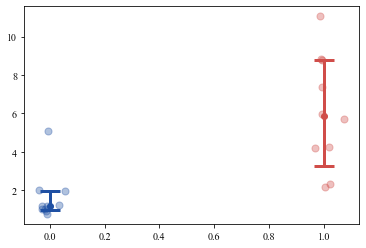

In [22]:
st_colors = ['#1F50A3','#D04D49']

for ms in np.unique(kms):
    m, cil, ciu = stats.bootstrap(np.asarray(hr_real[ms]), n_times=1000, median=True)
    print(m,cil,ciu)
    plt.scatter(0.03*np.random.randn(np.asarray(hr_real[ms]).shape[0])+ms, np.asarray(hr_real[ms]), s=50, alpha=.35, color=st_colors[ms])
    plt.errorbar(ms, m,[[m-cil[0]], [ciu[0]-m]], fmt='o', elinewidth=3, capsize=10, capthick=3, color=st_colors[ms])
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig3/lightlarge_mean_dt.pdf')
#     plt.yscale('log')

### Light 1x5

In [23]:
cond = 1
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]

# a = np.arange(condition_recs[9][0],condition_recs[9][1])
# b = np.arange(condition_recs[5][0],condition_recs[5][1])

# recs_ind = np.hstack([a,b])

maxL = np.max(lengths_all[cond_recs])

Light (1x5cm)


In [24]:
print(maxL)

time_Bout = time_Bout_allcond[cond_recs,:maxL]
X_head = X_head_allcond[cond_recs,:maxL]

stims = stims_allcond[cond_recs, :maxL]
bouttypes = bouttypes_allcond[cond_recs, :maxL]

4913


In [25]:
# recs_ind = np.hstack([a,b])

dtrajs_condition_phi1 = dtrajs_fish_phi1[cond_recs,:maxL]
dtrajs_condition_phi2 = dtrajs_fish_phi2[cond_recs,:maxL]

# dtrajs_condition = dtrajs_fish[recs_ind,:maxL]
print(dtrajs_condition_phi2.shape)

(12, 4913)


<ipython-input-26-d28f72b3647c>:20: UserWarning: linewidths is ignored by contourf
  im = ax.contourf(X,Y, img, cmap='Greys', linewidths=2, levels = 17)


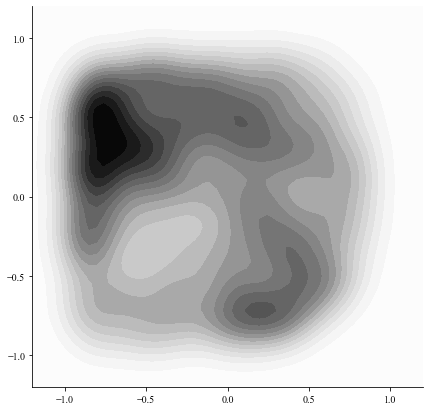

In [26]:
fig, ax  = plt.subplots(1,1,figsize=(7, 7))

# psi1[ecs_all.mask] = ma.masked
# psi2[ecs_all.mask] = ma.masked

xrange=[-1.2, +1.2]
yrange=[-1.2, +1.2]


psi1 = ma.concatenate(dtrajs_condition_phi1, axis=0)
psi2 = ma.concatenate(dtrajs_condition_phi2, axis=0)


# img= stats.density_plot(psi1.compressed()[::100], psi2.compressed()[::100], xrange, yrange, 50,50,smooth=True, border=3)

img= stats.density_plot(psi1.compressed(), psi2.compressed(), xrange, yrange, 50,50,smooth=True, border=3)


X,Y = np.meshgrid(np.linspace(-1.2,1.2,56), np.linspace(-1.2,1.2,56))
im = ax.contourf(X,Y, img, cmap='Greys', linewidths=2, levels = 17)


# im = ax.imshow(img, cmap='inferno', origin='lower')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.colorbar(im, ax=ax)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig3/lightsmall_mes_new.pdf')

In [27]:
cond = 1
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]

maxL = np.max(lengths_all[cond_recs])
# maxL = np.max(lengths_all[recs_ind])

cluster_fish_condition = cluster_fish[cond_recs,:maxL]
print(cluster_fish_condition.shape)
# cluster_traj = cluster_traj_all

Light (1x5cm)
(12, 4913)


In [28]:
time_Bout[time_Bout==0] = ma.masked
fps = 700.
lifetimessec_fish = [[],[],[],[]]
for i,cf in enumerate(cond_recs):
    print(cf)
    time_states = []
    for ms in np.unique(kms):
        sel = cluster_fish_condition[i] == ms
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        times = []
        for segment in segments:
            t0,tf = segment
            time_dur = (time_Bout[i,tf-1][1] - time_Bout[i,t0][0])/fps
            if time_dur > 0:
                times.append(time_dur)
        lifetimessec_fish[ms].append(times)

121
122
123
124
125
126
127
128
129
130
131
132


In [29]:
hr_real = [[],[],[],[]]
real_ciu = [[],[],[],[]]
real_cil = [[],[],[],[]]
for ms in np.unique(kms):
    dwell_times_real = lifetimessec_fish[ms]
    for cf in range(len(dwell_times_real)):
        print(cf)
        m, cil, ciu = stats.bootstrap(ma.hstack(dwell_times_real[cf]), n_times=100, n_samples=len(ma.hstack(dwell_times_real[cf])))
        hr_real[ms].append(m)
        real_cil[ms].append(np.hstack(cil))
        real_ciu[ms].append(np.hstack(ciu))

0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11


1.6680000420203378 [1.3541320961505914] [2.311401715137957]
2.216526016164958 [1.9742973774691568] [2.3522597982694737]


(1.0, 4.0)

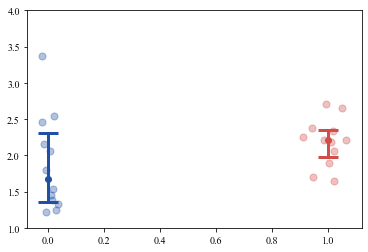

In [30]:
st_colors = ['#1F50A3','#D04D49']

for ms in np.unique(kms):
    m, cil, ciu = stats.bootstrap(np.asarray(hr_real[ms]), n_times=1000,median=True)
    print(m,cil,ciu)
    plt.scatter(0.03*np.random.randn(np.asarray(hr_real[ms]).shape[0])+ms, np.asarray(hr_real[ms]), s=50, alpha=.35, color=st_colors[ms])
    plt.errorbar(ms, m,[[m-cil[0]], [ciu[0]-m]], fmt='o', elinewidth=3, capsize=10, capthick=3, color=st_colors[ms])
plt.ylim(1,4)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig3/lightsmall_mean_dt.pdf')
#     plt.yscale('log')

### Dark 5x5

In [36]:
# Select condition

# cond = 5
print(condition_labels[3])
print(condition_labels[7])
# start_rec = condition_recs[cond][0]
# end_rec = condition_recs[cond][1]

a = np.where(conditions[:,1] == condition_labels[3])[0]
b = np.where(conditions[:,1] == condition_labels[7])[0]

recs_ind = np.hstack([a,b])
maxL = np.max(lengths_all[recs_ind])

Dark_Transitions(5x5cm)
Dark (5x5cm)


In [37]:
print(maxL)

time_Bout = time_Bout_allcond[recs_ind,:maxL]
X_head = X_head_allcond[recs_ind,:maxL]

stims = stims_allcond[recs_ind, :maxL]
bouttypes = bouttypes_allcond[recs_ind, :maxL]

10208


In [38]:
dtrajs_condition_phi1 = dtrajs_fish_phi1[recs_ind,:maxL]
dtrajs_condition_phi2 = dtrajs_fish_phi2[recs_ind,:maxL]

# dtrajs_condition = dtrajs_fish[recs_ind,:maxL]
print(dtrajs_condition_phi2.shape)

(37, 10208)


In [39]:
stims_copy = copy.deepcopy(stims)

stims_copy[stims_copy > 0] = ma.masked
stims_all = ma.concatenate(stims_copy, axis=0)

<ipython-input-40-eeccd3178239>:22: UserWarning: linewidths is ignored by contourf
  im = ax.contourf(X,Y, img, cmap='Greys', linewidths=2, levels = 17)


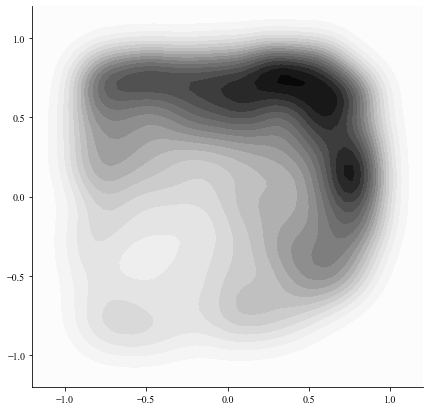

In [40]:
fig, ax  = plt.subplots(1,1,figsize=(7, 7))

# psi1[ecs_all.mask] = ma.masked
# psi2[ecs_all.mask] = ma.masked

xrange=[-1.2, +1.2]
yrange=[-1.2, +1.2]


psi1 = ma.concatenate(dtrajs_condition_phi1, axis=0)
psi2 = ma.concatenate(dtrajs_condition_phi2, axis=0)

psi1[stims_all.mask] = ma.masked
psi2[stims_all.mask] = ma.masked

# img= stats.density_plot(psi1.compressed()[::100], psi2.compressed()[::100], xrange, yrange, 50,50,smooth=True, border=3)

img= stats.density_plot(psi1.compressed(), psi2.compressed(), xrange, yrange, 50,50,smooth=True, border=3)


X,Y = np.meshgrid(np.linspace(-1.2,1.2,56), np.linspace(-1.2,1.2,56))
im = ax.contourf(X,Y, img, cmap='Greys', linewidths=2, levels = 17)


# im = ax.imshow(img, cmap='inferno', origin='lower')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.colorbar(im, ax=ax)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig3/darklarge_mes_new.pdf')

In [46]:
cluster_fish_condition = cluster_fish[recs_ind,:maxL]
print(cluster_fish_condition.shape)
# cluster_traj = cluster_traj_all

(37, 10208)


In [47]:
dx_recs = np.arange(10,len(recs_ind))
min_mark = []
for cf in dx_recs:
    mm = np.where(time_Bout[cf,:,1] > int(30*60*700))[0]
    if len(mm) != 0:
        min_mark.append(mm[0])
    else:
        min_mark.append(lengths_all[recs_ind][cf])

for i,cf in enumerate(dx_recs):
    m = min_mark[i]
    cluster_fish_condition[cf,m:] = ma.masked

In [48]:
time_Bout[time_Bout==0] = ma.masked
fps = 700.
lifetimessec_fish = [[],[],[],[]]
for i,cf in enumerate(recs_ind):
    print(cf)
    time_states = []
    for ms in np.unique(kms):
        sel = cluster_fish_condition[i] == ms
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        times = []
        for segment in segments:
            t0,tf = segment
            time_dur = (time_Bout[i,tf-1][1] - time_Bout[i,t0][0])/fps
            if time_dur > 0:
                times.append(time_dur)
        lifetimessec_fish[ms].append(times)

22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
443
444
445
446
447
448
449
450
451
452


In [49]:
hr_real = [[],[],[],[]]
real_ciu = [[],[],[],[]]
real_cil = [[],[],[],[]]
for ms in np.unique(kms):
    dwell_times_real = lifetimessec_fish[ms]
    for cf in range(len(dwell_times_real)):
        print(cf)
        m, cil, ciu = stats.bootstrap(ma.hstack(dwell_times_real[cf]), n_times=100, n_samples=len(ma.hstack(dwell_times_real[cf])))
        hr_real[ms].append(m)
        real_cil[ms].append(np.hstack(cil))
        real_ciu[ms].append(np.hstack(ciu))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


7.648307453416149 [6.150418719211823] [10.941060267857143]
4.665155142542133 [3.0651369863013698] [5.826533333333333]


(0.0, 30.0)

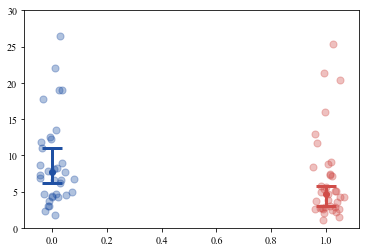

In [50]:
st_colors = ['#1F50A3','#D04D49']

for ms in np.unique(kms):
    m, cil, ciu = stats.bootstrap(np.asarray(hr_real[ms]), n_times=1000, median=True)
    print(m,cil,ciu)
    plt.scatter(0.03*np.random.randn(np.asarray(hr_real[ms]).shape[0])+ms, np.asarray(hr_real[ms]), s=50, alpha=.35, color=st_colors[ms])
    plt.errorbar(ms, m,[[m-cil[0]], [ciu[0]-m]], fmt='o', elinewidth=3, capsize=10, capthick=3, color=st_colors[ms])
plt.ylim(0,30)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig3/darklarge_mean_dt.pdf')
#     plt.yscale('log')

### PC Param Naive 2.5 x 2.5

In [51]:
cond = 9
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]

# a = np.arange(condition_recs[9][0],condition_recs[9][1])
# b = np.arange(condition_recs[5][0],condition_recs[5][1])

# recs_ind = np.hstack([a,b])

maxL = np.max(lengths_all[cond_recs])

Prey Capture Param. (2.5x2.5cm)


In [52]:
print(maxL)

time_Bout = time_Bout_allcond[cond_recs,:maxL]
X_head = X_head_allcond[cond_recs,:maxL]


ecs_pc = ecs_allcond[cond_recs,:maxL]
bouttypes = bouttypes_allcond[cond_recs, :maxL]

3068


In [53]:
# recs_ind = np.hstack([a,b])

dtrajs_condition_phi1 = dtrajs_fish_phi1[cond_recs,:maxL]
dtrajs_condition_phi2 = dtrajs_fish_phi2[cond_recs,:maxL]

# dtrajs_condition = dtrajs_fish[recs_ind,:maxL]
print(dtrajs_condition_phi2.shape)

(65, 3068)


In [54]:
stims_copy = copy.deepcopy(ecs_pc)
stims_copy = stims_copy - 1
stims_copy[stims_copy == 0] = ma.masked
stims_copy_all = ma.concatenate(stims_copy,axis=0)

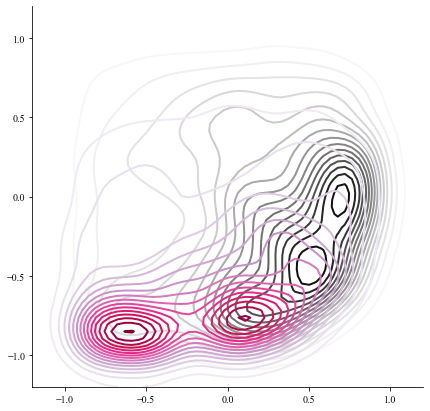

In [55]:
fig, ax  = plt.subplots(1,1,figsize=(7, 7))

# psi1[ecs_all.mask] = ma.masked
# psi2[ecs_all.mask] = ma.masked

xrange=[-1.2, +1.2]
yrange=[-1.2, +1.2]


psi1 = ma.concatenate(dtrajs_condition_phi1, axis=0)
psi2 = ma.concatenate(dtrajs_condition_phi2, axis=0)

psi1[~stims_copy_all.mask] = ma.masked
psi2[~stims_copy_all.mask] = ma.masked

img= stats.density_plot(psi1.compressed(), psi2.compressed(), xrange, yrange, 50,50,smooth=True, border=3)
X,Y = np.meshgrid(np.linspace(-1.2,1.2,56), np.linspace(-1.2,1.2,56))
im = ax.contour(X,Y, img, cmap='Greys', linewidths=2, levels = 17)


psi1 = ma.concatenate(dtrajs_condition_phi1, axis=0)
psi2 = ma.concatenate(dtrajs_condition_phi2, axis=0)
psi1[stims_copy_all.mask] = ma.masked
psi2[stims_copy_all.mask] = ma.masked
img= stats.density_plot(psi1.compressed(), psi2.compressed(), xrange, yrange, 50,50,smooth=True, border=3)


X,Y = np.meshgrid(np.linspace(-1.2,1.2,56), np.linspace(-1.2,1.2,56))
im = ax.contour(X,Y, img, cmap='PuRd', linewidths=2, levels = 17)


# im = ax.imshow(img, cmap='inferno', origin='lower')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.colorbar(im, ax=ax)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig3/PCparam_naive_ec_new.pdf')

In [56]:
cond = 9
print(condition_labels[cond])
cond_recs = np.where(conditions[:,1] == condition_labels[cond])[0]

maxL = np.max(lengths_all[cond_recs])
# maxL = np.max(lengths_all[recs_ind])

cluster_fish_condition = cluster_fish[cond_recs,:maxL]
print(cluster_fish_condition.shape)
# cluster_traj = cluster_traj_all

Prey Capture Param. (2.5x2.5cm)
(65, 3068)


In [57]:
time_Bout[time_Bout==0] = ma.masked
fps = 700.
lifetimessec_fish = [[],[],[],[]]
for i,cf in enumerate(cond_recs):
    print(cf)
    time_states = []
    for ms in np.unique(kms):
        sel = cluster_fish_condition[i] == ms
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        times = []
        for segment in segments:
            t0,tf = segment
            time_dur = (time_Bout[i,tf-1][1] - time_Bout[i,t0][0])/fps
            if time_dur > 0:
                times.append(time_dur)
        lifetimessec_fish[ms].append(times)

193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257


In [58]:
hr_real = [[],[],[],[]]
real_ciu = [[],[],[],[]]
real_cil = [[],[],[],[]]
for ms in np.unique(kms):
    dwell_times_real = lifetimessec_fish[ms]
    for cf in range(len(dwell_times_real)):
        print(cf)
        m, cil, ciu = stats.bootstrap(ma.hstack(dwell_times_real[cf]), n_times=100, n_samples=len(ma.hstack(dwell_times_real[cf])))
        hr_real[ms].append(m)
        real_cil[ms].append(np.hstack(cil))
        real_ciu[ms].append(np.hstack(ciu))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


4.135706563706564 [3.406706745303626] [5.056300366300366]
1.1453451581975072 [1.0301170960187354] [1.2887585577361935]


(0.0, 26.0)

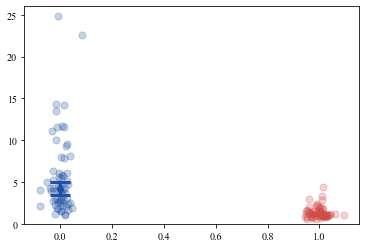

In [59]:
st_colors = ['#1F50A3','#D04D49']

for ms in np.unique(kms):
    m, cil, ciu = stats.bootstrap(np.asarray(hr_real[ms]), n_times=1000,median=True)
    print(m,cil,ciu)
    plt.scatter(0.03*np.random.randn(np.asarray(hr_real[ms]).shape[0])+ms, np.asarray(hr_real[ms]), s=50, alpha=.25, color=st_colors[ms])
    plt.errorbar(ms, m,[[m-cil[0]], [ciu[0]-m]], fmt='o', elinewidth=3, capsize=10, capthick=3, color=st_colors[ms])
plt.ylim(0,26)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig3/pc_paramnaive_mean_dt.pdf')
#     plt.yscale('log')